# LHS3844b's pandexo simulations of emission spectra models


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
import pandexo.engine.justplotit as jpi
import matplotlib.pyplot as plt
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 

import matplotlib
%matplotlib notebook

Setting up a run

In [14]:
exo_dict = jdi.load_exo_dict()
print(exo_dict.keys())
#print(exo_dict['star']['w_unit'])

dict_keys(['calculation', 'url', 'url_err', 'star', 'planet', 'observation'])


Exoplanet observation inputs

In [15]:
exo_dict['observation']['sat_level'] = 80    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

Exoplanet host star inputs

In [5]:
'''
fits_image_filename = astropy.io.fits.open('./Resources/GJ1214_stellar_spectrum.fits')
data = fits_image_filename[1].data
wav = np.array([data[i][0] for i in range(5000)])
Flux_lambda = np.array([data[i][1] for i in range(5000)])
nu = sc.c / (wav*1.0e-10)     # Convert wavelength (in Angstrom) into frequency (Hz)
Flux_nu = Flux_lambda * ((sc.c*1e10) / nu**2)   # Speed of light in Angstrom HZ converts from erg/cm^2/s/Angstrom into erg/cm^2/s/Hz

def write_stellar(nu, F_nu):
    
    # Write spectrum
    f = open('./Resources/'  + 'GJ1214_stellar.dat','w')
    
    for i in range(len(nu)):
        f.write('%.8e %.8e \n' %(nu[i], F_nu[i]))

write_stellar(wav*(10**-4), Flux_nu)
'''

"\nfits_image_filename = astropy.io.fits.open('./Resources/GJ1214_stellar_spectrum.fits')\ndata = fits_image_filename[1].data\nwav = np.array([data[i][0] for i in range(5000)])\nFlux_lambda = np.array([data[i][1] for i in range(5000)])\nnu = sc.c / (wav*1.0e-10)     # Convert wavelength (in Angstrom) into frequency (Hz)\nFlux_nu = Flux_lambda * ((sc.c*1e10) / nu**2)   # Speed of light in Angstrom HZ converts from erg/cm^2/s/Angstrom into erg/cm^2/s/Hz\n\ndef write_stellar(nu, F_nu):\n    \n    # Write spectrum\n    f = open('./Resources/'  + 'GJ1214_stellar.dat','w')\n    \n    for i in range(len(nu)):\n        f.write('%.8e %.8e \n' %(nu[i], F_nu[i]))\n\nwrite_stellar(wav*(10**-4), Flux_nu)\n"

In [16]:

'''
exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './Resources/GJ1214_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'erg/cm2/s/Hz'      
exo_dict['star']['mag'] = 9.750             # Magnitude of the system
exo_dict['star']['ref_wave'] = 1.25         # For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
'''


exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)

Exoplanet planet input for secondary eclipse with blackbody flux

In [17]:
exo_dict['planet']['type'] = 'constant'   
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'
exo_dict['planet']['radius'] = 0.116
exo_dict['planet']['r_unit'] = 'R_jup'            #Any unit of distance in accordance with astropy.units can be added here
exo_dict['star']['radius'] = 0.19
exo_dict['star']['r_unit'] = 'R_sun'              #Same deal with astropy.units here
exo_dict['planet']['f_unit'] = 'fp/f*'
exo_dict['planet']['temp'] = 1000    # approximate dayside temperature from Sptizer

Exoplanet planet input for secondary eclipse with precomputed model

In [21]:
exo_dict['planet']['exopath'] = './simulated_data/basalt.txt'
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'

Select instrument

In [35]:
inst_dict = jdi.load_mode_dict('MIRI LRS')

In [36]:
result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/', output_file='LHS3844b_emission_basalt_MIRI_LRS.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [2]:
#load in output from run
out = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS.p','rb'))
#for a single run
x,y,e = jpi.jwst_1d_spec(out, R=100, num_tran=1, model=True, plot=False)

In [3]:
model = np.loadtxt('./simulated_data/basalt.txt')

<IPython.core.display.Javascript object>


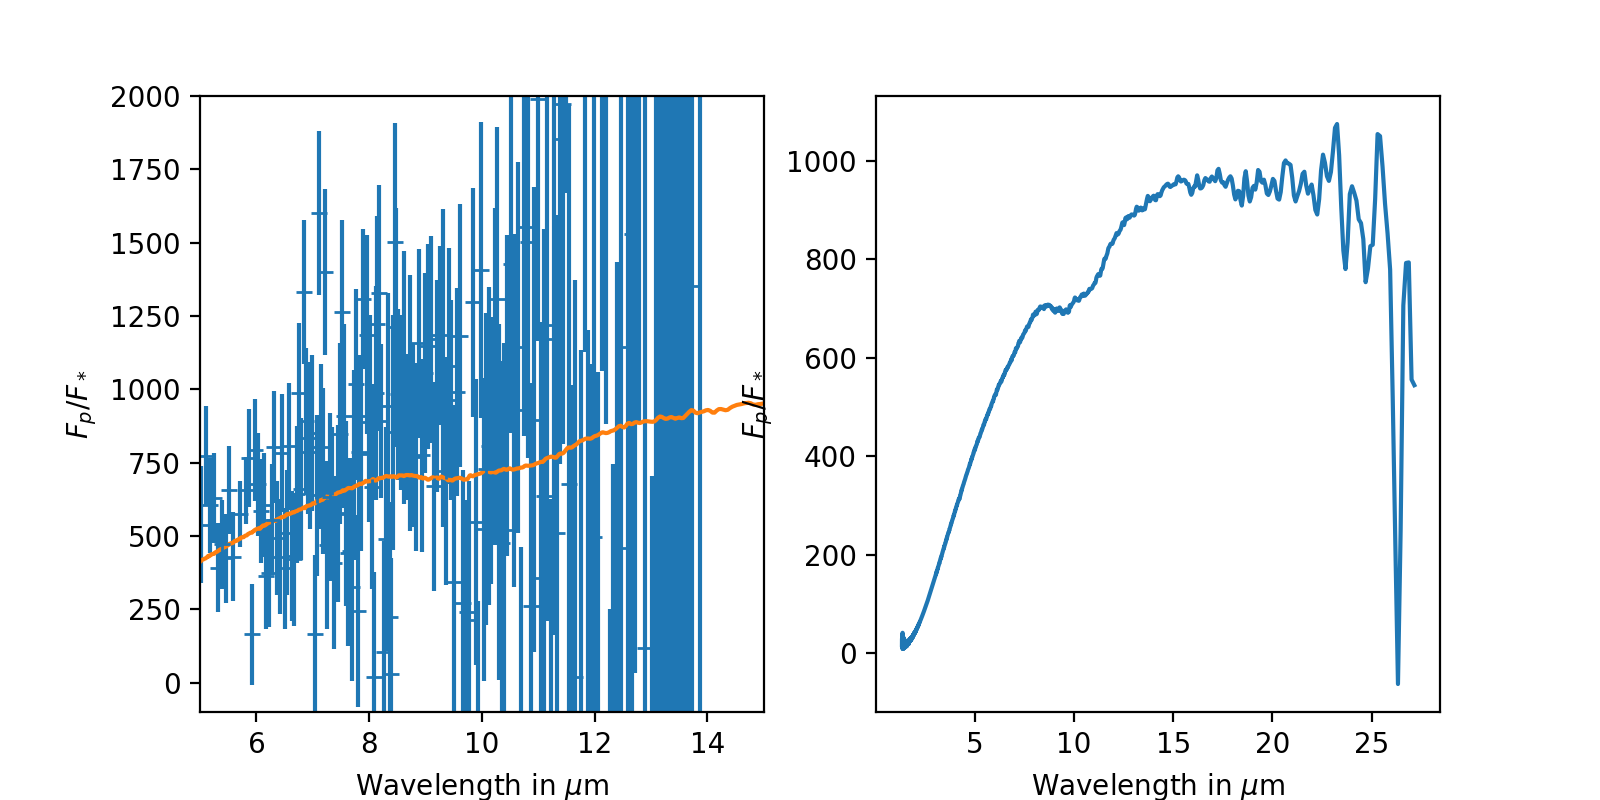

Text(0.5, 0, 'Wavelength in $\\mu$m')

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].errorbar(x[0],10**6*y[0],yerr=10**6*e[0], ls='', fmt='+')
ax[0].plot(model[:,0], 10**6*model[:,1])
ax[0].set_ylabel('$F_p/F_*$')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[1].plot(model[:,0], 10**6*model[:,1])
ax[1].set_ylabel('$F_p/F_*$')
ax[1].set_xlabel('Wavelength in $\mu$m')